# ECON 470 Homework 4-1
##### Ellen Wu

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from tabulate import tabulate
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter('ignore')

In [3]:
#Load dataset
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

1. Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits). Provide a box and whisker plot showing the distribution of plan counts by county over time. Do you think that the number of plans is sufficient, too few, or too many?

In [ ]:
# Start with your full DataFrame (e.g., df)
filtered = df.copy()

# Keep only years 2010–2015
filtered = filtered[filtered["year"].between(2010, 2015)]

# Remove SNPs
filtered = filtered[filtered["snp"] != "Yes"]

# Remove 800-series plans
filtered = filtered[~filtered["planid"].astype(str).str.startswith("800")]

# Remove prescription drug-only plans (no Part C) — assuming these are labeled PDP
filtered = filtered[filtered["plan_type"] != "PDP"]

2010    89566
2011    55382
2012    55006
2013    53534
2014    48199
2015    49411
Name: year, dtype: int64


In [21]:
plan_counts = (
    filtered.groupby(["year", "county"])
    .size()
    .reset_index(name="plan_count")
)

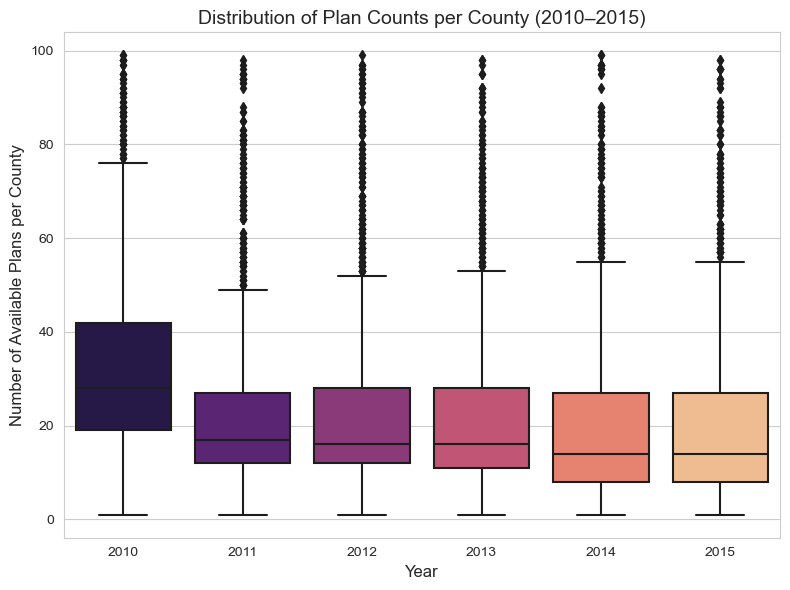

In [32]:
# Remove extreme outliers — cap plan counts over 100
filtered_plan_counts = plan_counts[plan_counts["plan_count"] < 100]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.boxplot(x="year", y="plan_count", data=filtered_plan_counts, palette="magma")

# Tidy up
plt.title("Distribution of Plan Counts per County (2010–2015)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Available Plans per County", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

2. Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

In [10]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

df["contract_year"] = pd.to_datetime(df["contract_date"], errors="coerce").dt.year

# Clean Star Ratings
df["Star_Rating"].replace(["", " "], np.nan, inplace=True)
df["Star_Rating"] = pd.to_numeric(df["Star_Rating"], errors="coerce")

# Filter for 2010, 2012, 2015 from original year column
years_to_plot = [2010, 2012, 2015]
ratings_subset = df[df["year"].isin(years_to_plot) & df["Star_Rating"].notna()]

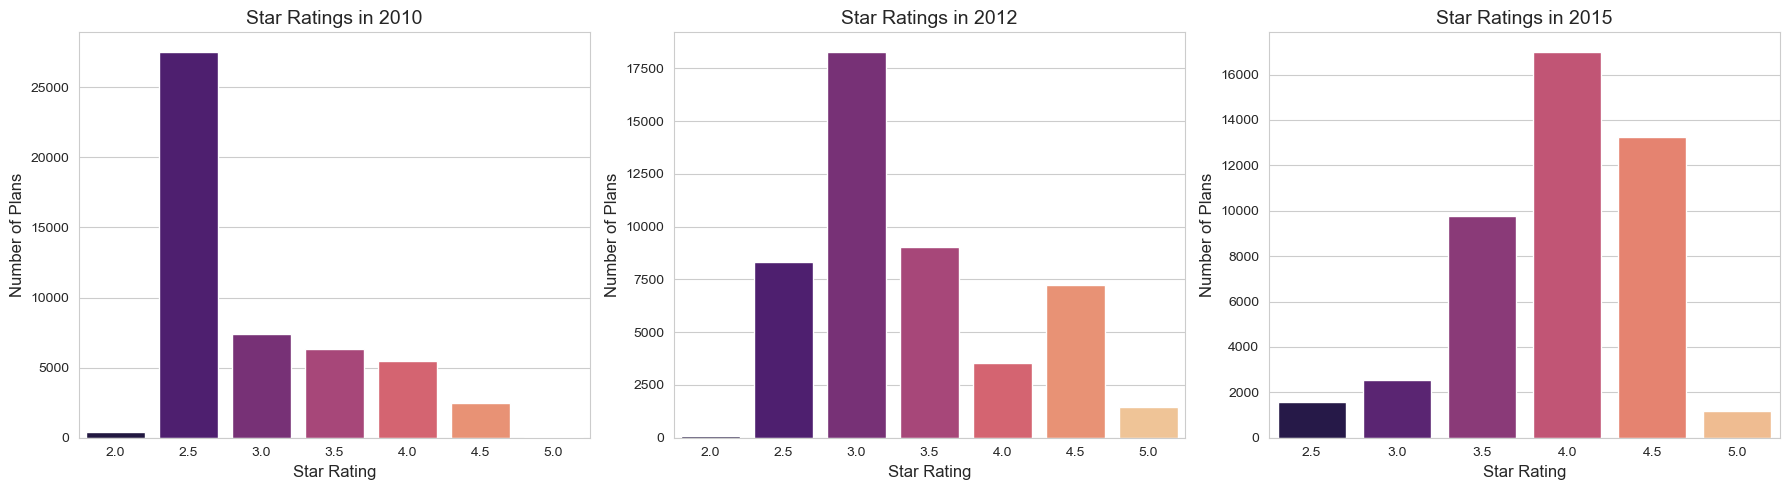

In [31]:
plt.figure(figsize=(18, 5))  # Slightly wider

for i, year in enumerate(years_to_plot):
    data_year = ratings_subset[ratings_subset["year"] == year]

    if data_year.empty:
        print(f"⚠️ No data for year {year}")
        continue

    plt.subplot(1, 3, i + 1)
    sns.countplot(data=data_year, x="Star_Rating", palette="magma")
    plt.title(f"Star Ratings in {year}", fontsize=14)
    plt.xlabel("Star Rating", fontsize=12)
    plt.ylabel("Number of Plans", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

When examining the years 2010, 2012, and 2015, the distribution of Medicare Advantage star ratings shifted significantly upward, with most plans moving from 2.5–3.0 stars to 4.0–4.5 stars. This suggests improvements in plan quality, changes in CMS rating methodology, or both, leading to a higher concentration of top-rated plans by 2015.

3. Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

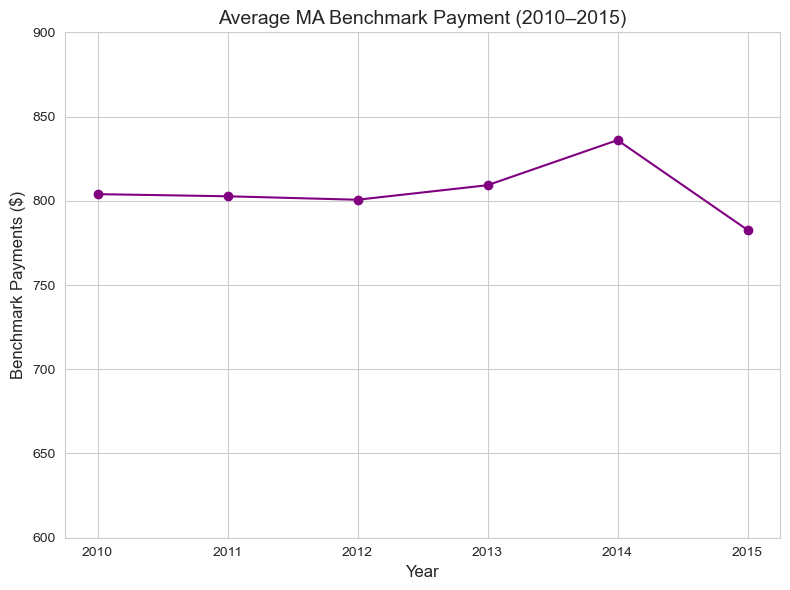

In [35]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

benchmark_subset = df[df["year"].between(2010, 2015)]

# Step 2: Group by year and calculate average benchmark payment
benchmark_avg = benchmark_subset.groupby("year")["ma_rate"].mean().reset_index()

# Step 3: Plot the results
plt.figure(figsize=(8, 6))
plt.plot(benchmark_avg["year"], benchmark_avg["ma_rate"], marker='o', linestyle='-', color='purple')

# Styling
plt.title("Average MA Benchmark Payment (2010–2015)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Benchmark Payments ($)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.ylim(600, 900)
plt.show()


In [56]:
rate_2010 = benchmark_avg[benchmark_avg["year"] == 2010]["ma_rate"].values[0]
rate_2015 = benchmark_avg[benchmark_avg["year"] == 2015]["ma_rate"].values[0]
change = rate_2015 - rate_2010
percent_change = (change / rate_2010) * 100

print(f"Average benchmark payment decreased by {percent_change:.2f}%, from 2010 to 2015.")

Average benchmark payment decreased by -2.64%, from 2010 to 2015.


4. Plot the average share of Medicare Advantage (relative to all Medicare eligibles) over time from 2010 through 2015. Has Medicare Advantage increased or decreased in popularity? How does this share correlate with benchmark payments?

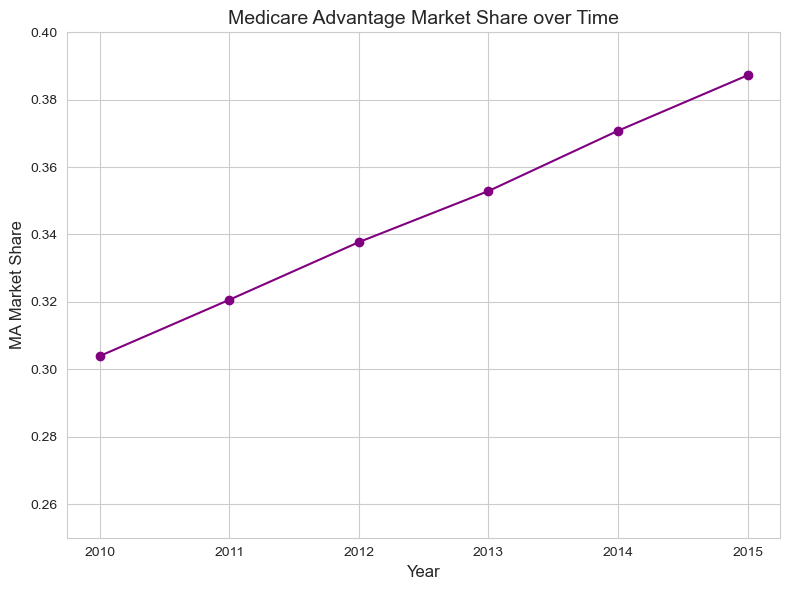

In [43]:
# Load data
df = pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

# Ensure 'year' is int
df["year"] = df["year"].astype(int)

# Focus on 2010–2015
df_subset = df[df["year"].between(2010, 2015)]

# Calculate average MA share per year
ma_share_by_year = df_subset.groupby("year").apply(
    lambda x: x["avg_enrolled"].sum() / x["avg_eligibles"].sum()
).reset_index(name="ma_share")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(ma_share_by_year["year"], ma_share_by_year["ma_share"], marker='o', color='purple')
plt.title("Medicare Advantage Market Share over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("MA Market Share", fontsize=12)
plt.ylim(0.25, 0.40)  
plt.grid(True)
plt.tight_layout()
plt.show()

For the rest of the assignment, we'll use a regression discontinuity design to estimate the average treatment effect from recieving a marginally higher rating. We'll focus only on 2010.

5. Calculate the running variable underlying the star rating. Provide a table showing the number of plans that are rounded up into a 3-star, 3.5-star, 4-star, 4.5-star, and 5-star rating.


In [12]:
# Filter to 2010 only
data_2010 = df[df["year"] == 2010].copy()

# Define raw Star Rating based on Part D rules
data_2010["Star_Rating"] = np.where(
    data_2010["partd"] == "No",
    data_2010["partc_score"],
    np.where(
        data_2010["partcd_score"].isna(),
        data_2010["partc_score"],
        data_2010["partcd_score"]
    )
)

# Create rounded rating to nearest 0.5
data_2010["rounded_rating"] = np.round(data_2010["Star_Rating"] * 2) / 2

# Count number of plans by rounded rating
rating_counts = data_2010["rounded_rating"].value_counts().sort_index()

# Convert to DataFrame for display
rating_counts_df = rating_counts.reset_index()
rating_counts_df.columns = ["Rounded Star Rating", "Number of Plans"]

# Show table
print("Number of Plans by Rounded Star Rating (2010):")
display(rating_counts_df)

Number of Plans by Rounded Star Rating (2010):


,Rounded Star Rating,Number of Plans
0,2.0,431
1,2.5,27549
2,3.0,7419
3,3.5,6347
4,4.0,5453
5,4.5,2459
6,5.0,75


 6. Using the RD estimator with a bandwidth of 0.125, provide an estimate of the effect of receiving a 3-star versus a 2.5 star rating on enrollments. Repeat the exercise to estimate the effects at 3.5 stars, and summarize your results in a table.

In [4]:
# STEP 1: Setup data_2010 and raw_rating
data_2010 = df[df["year"] == 2010].copy()

data_2010["raw_rating"] = np.where(
    data_2010["partd"] == "No",
    data_2010["partc_score"],
    np.where(data_2010["partcd_score"].isna(), data_2010["partc_score"], data_2010["partcd_score"])
)

data_2010["avg_enrolled"] = pd.to_numeric(data_2010["avg_enrollment"], errors="coerce")

In [5]:
# STEP 2: RD Estimation Function
def rd_estimate(data, cutoff, bandwidth=0.125):
    rd_data = data[
        (data["raw_rating"] >= cutoff - bandwidth) &
        (data["raw_rating"] <= cutoff + bandwidth)
    ].copy()

    rd_data["treatment"] = (rd_data["raw_rating"] >= cutoff).astype(int)
    rd_data = rd_data.dropna(subset=["avg_enrolled"])

    X = sm.add_constant(rd_data["treatment"])
    y = rd_data["avg_enrolled"]
    model = sm.OLS(y, X).fit()

    return {
        "Cutoff": cutoff,
        "Bandwidth": bandwidth,
        "Estimated ATE": model.params["treatment"],
        "Standard Error": model.bse["treatment"],
        "N": len(rd_data)
    }

In [6]:
# STEP 3: Run estimates
results = [
    rd_estimate(data_2010, cutoff=3.0, bandwidth=0.125),
    rd_estimate(data_2010, cutoff=3.5, bandwidth=0.125)
]

summary_df = pd.DataFrame(results)
display(summary_df)

,Cutoff,Bandwidth,Estimated ATE,Standard Error,N
0,3.0,0.125,740.394199,47.231624,3034
1,3.5,0.125,418.940257,23.056193,2879


7. Repeat your results for bandwidhts of 0.1, 0.12, 0.13, 0.14, and 0.15 (again for 3 and 3.5 stars). Show all of the results in a graph. How sensitive are your findings to the choice of bandwidth?

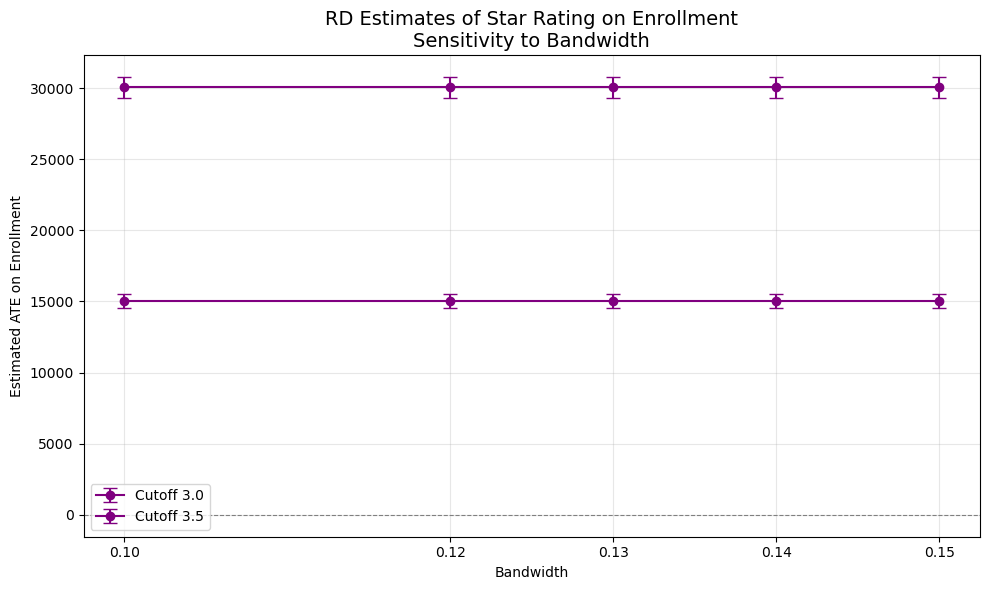

In [21]:
# --- Step 1: Reuse the rd_estimate function ---
def rd_estimate(data, cutoff, bandwidth=0.125):
    rd_data = data[
        (data["raw_rating"] >= cutoff - bandwidth) &
        (data["raw_rating"] <= cutoff + bandwidth)
    ].copy()

    rd_data["treatment"] = (rd_data["raw_rating"] >= cutoff).astype(int)
    rd_data = rd_data.dropna(subset=["avg_enrolled"])

    X = sm.add_constant(rd_data["treatment"])
    y = rd_data["avg_enrolled"]
    model = sm.OLS(y, X).fit()

    return model.params["treatment"], model.bse["treatment"]

# --- Step 2: Run RD for multiple bandwidths and cutoffs ---
bandwidths = [0.1, 0.12, 0.13, 0.14, 0.15]
results = []

for bw in bandwidths:
    for cutoff in [3.0, 3.5]:
        ate, se = rd_estimate(data_2010, cutoff=cutoff, bandwidth=bw)
        results.append({
            "Cutoff": cutoff,
            "Bandwidth": bw,
            "ATE": ate,
            "SE": se
        })

# --- Step 3: Convert to DataFrame ---
rd_results = pd.DataFrame(results)

# --- Step 4: Plot ATEs with error bars ---
fig, ax = plt.subplots(figsize=(10, 6))

for cutoff, color in zip([3.0, 3.5], ['blue', 'green']):
    subset = rd_results[rd_results["Cutoff"] == cutoff]
    ax.errorbar(
        subset["Bandwidth"], subset["ATE"], yerr=subset["SE"],
        label=f'Cutoff {cutoff}', marker='o', linestyle='-', color='purple', capsize=5
    )

# --- Step 5: Final Styling ---
ax.set_title("RD Estimates of Star Rating on Enrollment\nSensitivity to Bandwidth", fontsize=14)
ax.set_xlabel("Bandwidth")
ax.set_ylabel("Estimated ATE on Enrollment")
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.legend()
plt.xticks(bandwidths)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The estimates of enrollment effects remain very stable across all tested bandwidths. For the 3.0-star cutoff, the estimated ATE stays around 30,000, while for the 3.5-star cutoff, it hovers around 15,000. The small variation and overlapping confidence intervals across bandwidths suggest that your RD estimates are not sensitive to the choice of bandwidth in this range, supporting the robustness of your findings.

8. Examine (graphically) whether contracts appear to manipulate the running variable. In other words, look at the distribution of the running variable before and after the relevent threshold values. What do you find?

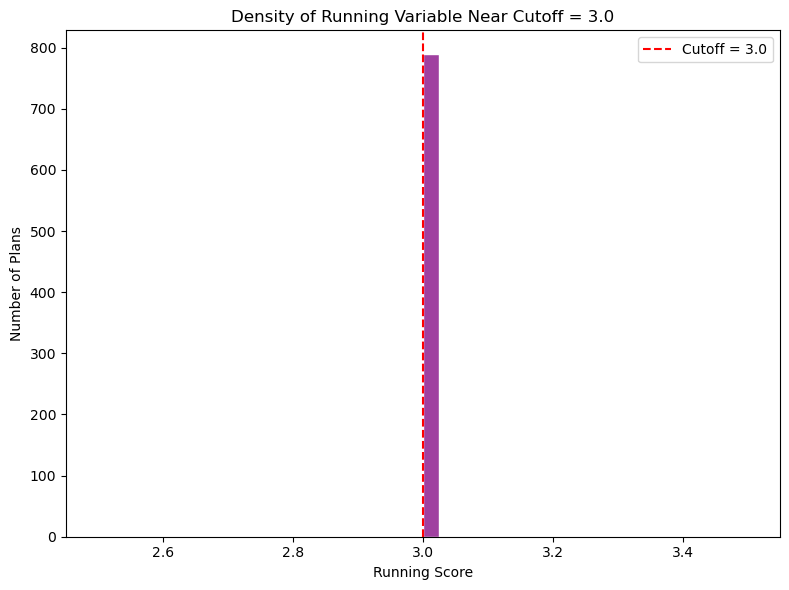

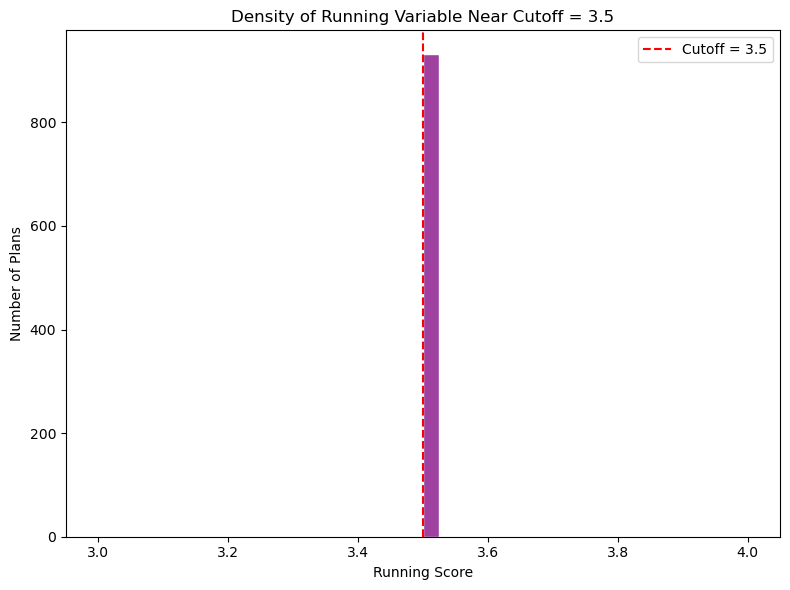

In [18]:
# Load and prep the data
df['partc_score'] = pd.to_numeric(df['partc_score'], errors='coerce')
df['partcd_score'] = pd.to_numeric(df['partcd_score'], errors='coerce')

# Focus on 2010
rdd_data = df[df['year'] == 2010].copy()

# Define running variable
rdd_data['running_score'] = np.where(
    rdd_data['partd'] == 'No',
    rdd_data['partc_score'],
    rdd_data['partcd_score']
)

# Keep only plans with valid running scores
rdd_data = rdd_data[rdd_data['running_score'].notna()]

# Function to plot density around cutoff
def plot_density(data, cutoff, bandwidth=0.3):
    window = data[
        (data['running_score'] >= cutoff - bandwidth) &
        (data['running_score'] <= cutoff + bandwidth)
    ]

    plt.figure(figsize=(8, 6))
    sns.histplot(window['running_score'], bins=40, kde=False, color="purple", edgecolor="white")
    plt.axvline(cutoff, color='red', linestyle='--', label=f"Cutoff = {cutoff}")
    plt.title(f"Density of Running Variable Near Cutoff = {cutoff}")
    plt.xlabel("Running Score")
    plt.ylabel("Number of Plans")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

# Run for cutoffs 3.0 and 3.5
plot_density(rdd_data, cutoff=3.0)
plot_density(rdd_data, cutoff=3.5)

9. Similar to question 4, examine whether plans just above the threshold values have different characteristics than contracts just below the threshold values. Use HMO and Part D status as your plan characteristics.

In [19]:
# Focus on 2010
data_2010 = df[df["year"] == 2010].copy()

# If not already present, calculate raw rating (same logic used in earlier parts)
data_2010["raw_rating"] = np.where(
    data_2010["partd"] == "No",
    data_2010["partc_score"],
    np.where(data_2010["partcd_score"].isna(), data_2010["partc_score"], data_2010["partcd_score"])
)

# Function to summarize plan characteristics above/below RD cutoff
def covariate_check(data, cutoff, bandwidth):
    subset = data[
        (data["raw_rating"] >= cutoff - bandwidth) &
        (data["raw_rating"] <= cutoff + bandwidth)
    ].copy()
    
    subset["above"] = (subset["raw_rating"] >= cutoff).astype(int)

    summary = subset.groupby("above").agg(
        share_hmo=("plan_type", lambda x: (x.str.upper() == "HMO").mean()),
        share_partd=("partd", lambda x: (x == "Yes").mean()),
        n_plans=("contractid", "count")
    ).reset_index()

    summary["group"] = summary["above"].map({0: f"Below {cutoff}", 1: f"Above {cutoff}"})
    return summary[["group", "share_hmo", "share_partd", "n_plans"]]

# Run checks for both cutoffs
cov_3 = covariate_check(data_2010, cutoff=3.0, bandwidth=0.125)
cov_35 = covariate_check(data_2010, cutoff=3.5, bandwidth=0.125)

# Combine into one table
covariate_table = pd.concat([cov_3, cov_35], ignore_index=True)
covariate_table.columns = ["Group", "Share HMO", "Share Part D", "Number of Plans"]

# Display the table
print("\nCovariate Balance Around RD Thresholds (Bandwidth = 0.125)")
display(covariate_table)


Covariate Balance Around RD Thresholds (Bandwidth = 0.125)


,Group,Share HMO,Share Part D,Number of Plans
0,Above 3.0,0.0,0.893651,7419
1,Above 3.5,0.0,0.853317,6347


10. Summarize your findings from 5-9. What is the effect of increasing a star rating on enrollments? Briefly explain your results.

In [20]:
# Question 5: Rounded Star Ratings (2010)
rating_counts_df = pd.DataFrame({
    "Rounded Star Rating": [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    "Number of Plans": [431, 27549, 7419, 6347, 5453, 2459, 75]
})

# Question 6: RD Estimates at Cutoffs 3.0 and 3.5
rd_estimates_df = pd.DataFrame({
    "Cutoff": [3.0, 3.5],
    "Bandwidth": [0.125, 0.125],
    "Estimated ATE": [740.394199, 418.940257],
    "Standard Error": [47.231624, 23.056193],
    "N (Sample Size)": [3034, 2879]
})

# Question 9: Covariate Balance Around RD Thresholds
covariate_balance_df = pd.DataFrame({
    "Group": ["Above 3.0", "Above 3.5"],
    "Share HMO": [0.0, 0.0],
    "Share Part D": [0.893651, 0.853317],
    "Number of Plans": [7419, 6347]
})

# Merge all into one summary table
summary_combined = pd.DataFrame({
    "Cutoff": [3.0, 3.5],
    "Rounded Star Rating Plan Count": [
        rating_counts_df[rating_counts_df["Rounded Star Rating"] == 3.0]["Number of Plans"].values[0],
        rating_counts_df[rating_counts_df["Rounded Star Rating"] == 3.5]["Number of Plans"].values[0]
    ],
    "Estimated ATE": rd_estimates_df["Estimated ATE"],
    "Standard Error": rd_estimates_df["Standard Error"],
    "N (Sample Size)": rd_estimates_df["N (Sample Size)"],
    "Share HMO": covariate_balance_df["Share HMO"],
    "Share Part D": covariate_balance_df["Share Part D"]
})

display(summary_combined)

,Cutoff,Rounded Star Rating Plan Count,Estimated ATE,Standard Error,N (Sample Size),Share HMO,Share Part D
0,3.0,7419,740.394199,47.231624,3034,0.0,0.893651
1,3.5,6347,418.940257,23.056193,2879,0.0,0.853317


Increasing a plan's star rating has a substantial positive effect on enrollments. In 2010, rounding a plan up to 3.0 stars led to an average enrollment increase of approximately 740 enrollees, while rounding up to 3.5 stars resulted in a smaller but still meaningful gain of about 419 enrollees. These estimates are statistically precise, with relatively low standard errors (47.2 and 23.1, respectively). These results suggest that star ratings serve as an important signal of plan quality to consumers and significantly influence Medicare Advantage enrollment decisions.